<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогозирование-методом-LSTM" data-toc-modified-id="Прогозирование-методом-LSTM-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Прогозирование методом LSTM</a></span></li><li><span><a href="#Прогнозирование-методом-Random-Forest" data-toc-modified-id="Прогнозирование-методом-Random-Forest-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Прогнозирование методом Random Forest</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

# <p style='text-align:center; color:blue'> Прогнозирование нагрузки группы солнечных электростанций Оренбургской энергосистемы </p><a class="tocSkip">
    
## <p style='text-align:center; color:blue'> Часть 4. Сравнение работы моделей RFR и LSTM на новых данных </p><a class="tocSkip">

In [1]:
# загрузка стандартных библиотек для обработки и визуализации данных

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from pandas import Series
sns.set(style="darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
sns.set(style="darkgrid")

# загрузка библиотек для использования машинного обучения

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pickle

Загружаем новые данные

In [2]:
df = pd.read_csv('E:\EZG\VIE\solar_df_test\solar_df_test.csv')

In [3]:
features_considered = [
         'load_rate',
         'temp', 
         'cloudiness', 
         'rainfall_rate', 
         'month', 
         'hour',
         'rainfall_type_Слабый дождь', 
         'rainfall_type_Слабый снег', 
         'rainfall_type_Умеренный дождь', 
         'rainfall_type_Умеренный снег', 
         'rainfall_type_б/о'
       ]
df['rainfall_type_Слабый снег'] = 0
df['rainfall_type_Умеренный снег'] = 0
features = df[features_considered]
features.index = df['date']
features.head()

,load_rate,temp,cloudiness,rainfall_rate,month,hour,rainfall_type_Слабый дождь,rainfall_type_Слабый снег,rainfall_type_Умеренный дождь,rainfall_type_Умеренный снег,rainfall_type_б/о
date,,,,,,,,,,,
2023-05-03 05:00:00,0.000000,10.500000,0.200000,0.0,5,5,0,0,0,0,1
2023-05-03 06:00:00,0.000000,11.166667,0.233333,0.0,5,6,0,0,0,0,1
2023-05-03 07:00:00,0.052771,11.833333,0.266667,0.0,5,7,0,0,0,0,1
2023-05-03 08:00:00,0.185693,12.500000,0.300000,0.0,5,8,0,0,0,0,1
2023-05-03 09:00:00,0.372203,15.033333,0.400000,0.0,5,9,0,0,0,0,1


###  Прогозирование методом LSTM

In [4]:
dataset = features.values

In [5]:
def multivariate_data(dataset, 
                      target, 
                      start_index, 
                      end_index, 
                      history_size,
                      target_size,
                      step, 
                      single_step=False):
    # функция, разбивающая датасет на наборы данных размерностью (42,120,11) и наборы значений цплпвой переменной 
    # размерностью (42,24).
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, 24):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [6]:
past_history = 120
future_target = 24
TRAIN_SPLIT = 1147
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, 
                                                 dataset[:, 0], 
                                                 19,
                                                 TRAIN_SPLIT, 
                                                 past_history,
                                                 future_target, 
                                                 STEP)

In [7]:
x_train_multi.shape

(42, 120, 11)

In [8]:
y_train_multi.shape

(42, 24)

Таким образом, в нашем распоряжении 42 набора данных по 120 последовательных наблюдений 11 параметров. И 42 24-часовых соответстыющих вектора целевой переменной.

In [7]:
def create_time_steps(length):
    return list(range(-length, 0))

In [8]:
def multi_step_plot(history, true_future, prediction, title):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.title(title)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [9]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

Загружаем модель

In [10]:
multi_step_model = tf.keras.models.load_model('E:\EZG\VIE\solar_lstm\multi_step_model.h5')

Строим предсказание для первого дня из нашего набора

1/1 [==============================] - 2s 2s/step


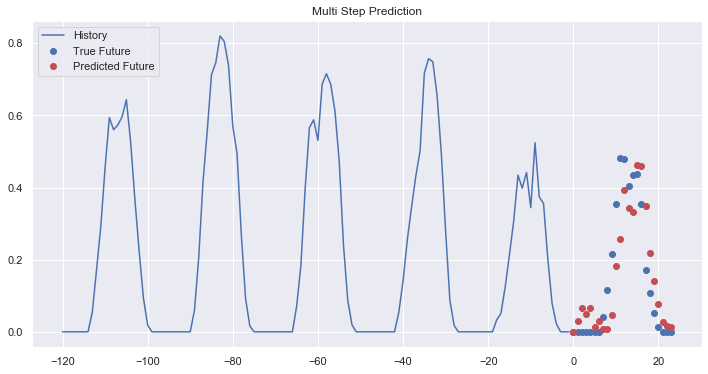

In [11]:
day_number = 0
plot = multi_step_plot(x_train_multi[day_number], 
                       y_train_multi[day_number],
                       multi_step_model.predict(x_train_multi[day_number].reshape((1,120,11))).reshape(24,), 
                       'Multi Step Prediction')

In [12]:
def mape_function(df):
    # функция, вычисляющая MAPE для одних суток
    df['MAPE, %'] = 100*abs(df['fact'] - df['prediction'])/df['fact'].max()
    return(round(df['MAPE, %'].mean(),2))

Строим предсказания для всех 42 дней и отмечаем на графике значение МАРЕ для каждых суток

1/1 [==============================] - 0s 64ms/step


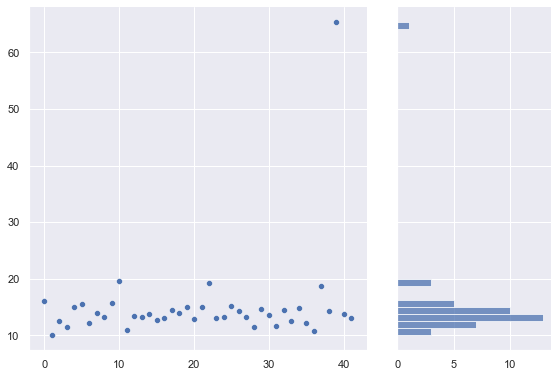

In [16]:
mape_lstm=[]
for i in range(42):
    predictions = multi_step_model.predict(x_train_multi[i].reshape((1,120,11))).reshape(24,)
    results = pd.DataFrame({"fact": y_train_multi[i],
                            "prediction": predictions})
    mape_lstm.append(mape_function(results))
    
sns.jointplot(
              data=mape_lstm, 
              kind='scatter', 
              height=8, 
              ratio=2,
              marginal_ticks=True   
             ).ax_marg_x.remove()   

### Прогнозирование методом Random Forest

Загружаем модель

In [21]:
rfr_model = pickle.load(open(r'E:\EZG\VIE\solar_rfr\solar_rfr.pickle', 'rb'))

In [22]:
features_considered_rfr = [
         #'load_rate',
         'temp', 
         'cloudiness', 
         'rainfall_rate', 
         'month', 
         'hour',
         'rainfall_type_Слабый дождь', 
         'rainfall_type_Слабый снег', 
         'rainfall_type_Умеренный дождь', 
         'rainfall_type_Умеренный снег', 
         'rainfall_type_б/о'
       ]

features_rfr = df[features_considered_rfr]
features_rfr.index = df['date']
features_rfr.head()

,temp,cloudiness,rainfall_rate,month,hour,rainfall_type_Слабый дождь,rainfall_type_Слабый снег,rainfall_type_Умеренный дождь,rainfall_type_Умеренный снег,rainfall_type_б/о
date,,,,,,,,,,
2023-05-03 05:00:00,10.500000,0.200000,0.0,5,5,0,0,0,0,1
2023-05-03 06:00:00,11.166667,0.233333,0.0,5,6,0,0,0,0,1
2023-05-03 07:00:00,11.833333,0.266667,0.0,5,7,0,0,0,0,1
2023-05-03 08:00:00,12.500000,0.300000,0.0,5,8,0,0,0,0,1
2023-05-03 09:00:00,15.033333,0.400000,0.0,5,9,0,0,0,0,1


In [23]:
def multivariate_data_rfr(dataset, 
                          target, 
                          start_index, 
                          end_index):
    data = []
    labels = []


    for i in range(start_index, end_index, 24):
        indices = range(i, i+24, 1)
        data.append(dataset[indices,1:11])
        labels.append(target[indices])
        
    return np.array(data), np.array(labels)


Разбиваем данные на 42 набора

In [24]:
x_train_rfr, y_train_rfr = multivariate_data_rfr(dataset, 
                                                 dataset[:, 0], 
                                                 139,
                                                 1147)

Строим предсказания для первых из 42 суток

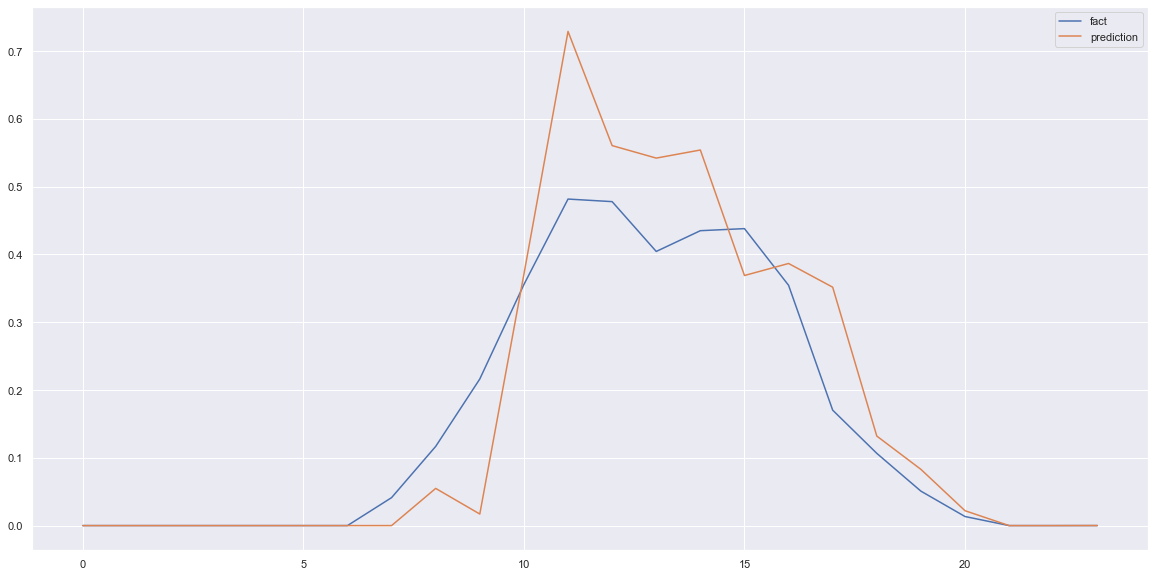

In [26]:
ss = StandardScaler()
predictions_test = rfr_model.predict(ss.fit_transform(x_train_rfr[0])) 
results = pd.DataFrame({"fact": y_train_rfr[0],
                        "prediction": predictions_test})
fig, ax = plt.subplots(figsize=(20,10)) 
results.plot(ax = ax)

Строим предсказания для всех 42 дней и отмечаем на графике значение МАРЕ для каждых суток

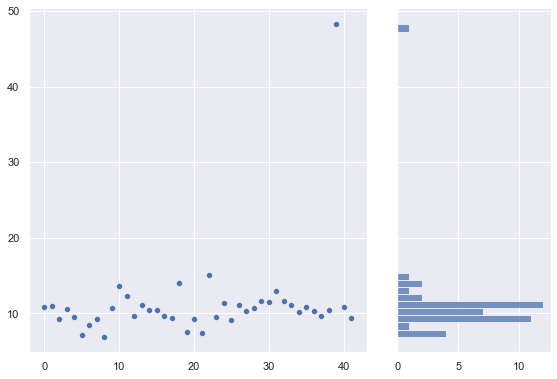

In [27]:
mape_rfr=[]
for i in range(42):
    predictions_test = rfr_model.predict(ss.fit_transform(x_train_rfr[i]))
    results = pd.DataFrame({"fact": y_train_rfr[i],
                            "prediction": predictions_test})
    mape_rfr.append(mape_function(results))
    
sns.jointplot(
              data=mape_rfr, 
              kind='scatter', 
              height=8, 
              ratio=2,
              marginal_ticks=True   
             ).ax_marg_x.remove()      

Строим сравнительный график, на котором отмечаем значения МАРЕ для каждых суток, полученные двумя методами.

In [30]:
mape = pd.DataFrame({"mape_lstm": mape_lstm,
                    "mape_rfr": mape_rfr})

На срезе данных длиной 42 дня:


,mape_lstm,mape_rfr
count,42.000000,42.000000
mean,15.042143,11.316190
std,8.200295,6.074608
min,10.090000,6.940000
25%,12.712500,9.475000
50%,13.610000,10.495000
75%,14.865000,11.137500
max,65.310000,48.230000


Среднtt значение ошибки MAPE по методу random forest regressor ниже, чем по методу lstm, то есть random forest regressor показывает более точный результат


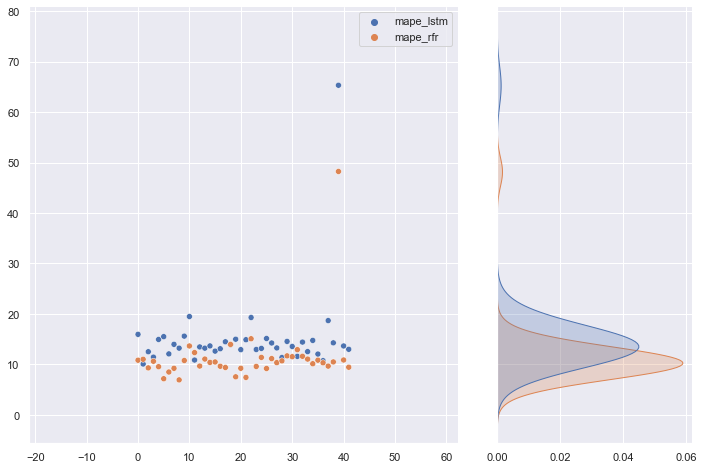

In [32]:
sns.jointplot(
              data=mape, 
              kind='scatter', 
              height=10, 
              ratio=2,
              marginal_ticks=True   
             ).ax_marg_x.remove()
print('На срезе данных длиной 42 дня:')
display(mape.describe())
print('Среднtt значение ошибки MAPE по методу random forest regressor ниже, чем по методу lstm, то есть random forest regressor показывает более точный результат')

### Вывод:

По результатам тестирования двух моделей видно, что средняя относительная ошибка прогнозирования для метода Random Forest оказалась меньше, чем для модели LSTM(11,3% против 15%), то есть прогнозирование методом Random Forest точнее. Поскольку, как видно на рисунке выше, в точности прогнозирования имеются редкие спорадические выбросы, правильнее ориентироваться не на среднее, а на медиану. Поэтому, примем, что в результате нашего исследования мы получили точность прогноза 10,5%.

Более совершенный и сложный метод LSTM не обеспечил более точного результата. Причина этому кроется, вероятнее всего, в особенностях конкретных данных. Как было сказано выше, данный метод работает хорошо при прогнозировании непрерывной во времени изменяющейся величины, где каждое последующее значение зависит от предшествующих, где есть повторяющиеся тренды на коротких и длинных периодах.

В нашей задаче рассматривается величина генерации солнечных станций, которая такими свойствами не обладает. Как было сказано выше, определяющий фактор здесь – освещенность, а она может носить абсолютно непредсказуемый характер – условно, если 2 или 3 предыдущих дня были солнечными, вовсе не означает, что следующий день будет солнечным. В данном случае при прогнозировании правильнее опираться на прогнозные метеоданные, чем на статистику последних дней. 

Полученная величина MAРE равная 10,5% - достаточно велика. Причины такой высокой погрешности вероятнее всего в том, что прогноз строится не на основании точных и безусловных данных, а на прогнозных метеофакторах, которые, как известно, тоже весьма неточны.
Тем не менее, данное исследование показало, что нагрузку солнечных станций можно прогнозировать с определенной точностью, вероятно, достаточной для практического применения.    
